### **Introducción a Ciencia de Datos**

### **Proyecto 1**

+ Laura Gómez Bustamante (191294)
+ Miguel Angel Millán Dorado (191470)

#### **Introducción**

El análisis que a continuación se presenta corresponde a una base de datos sobre procedimientos de Interrupción Legal del Embarazo (ILE) realizados en las clínicas y hospitales de la Secretaría de Salud de la Ciudad de México, durante el periodo enero 2016 a octubre 2019. La base de datos está formado por 36 variables y 62,003 observaciones.
Dicha información se encuentra disponible en la siguiente dirección:
 https://datos.cdmx.gob.mx/explore/dataset/interrupcion-legal-del-embarazo/table/

El objetivo que se establece es utilizar algoritmos de *Machine Learning* para desarrollar un modelo que sea capaz  de predecir si la edad de la persona que llega a realizarse la interrupción legal del embarazo pertenece a alguna de las siguientes catergorías:

+ Mayor o igual a 23 años
+ Menor a 23 años

En este contexto se plantea que el gobierno utilice esta información para diseñar campañas de prevención de embarazos para las mujeres del primer grupo, es decir cuya edad es mayor o igual a 23 años.  

El documento está conformado por las siguientes cuatro secciones:

1. Análisis Exploratorio de Datos
2. Selección de Variables
3. Modelado
4. Implicaciones Éticas

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di 
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import clean_data
import load_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sms
import transform_data
 
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier

#### **1. Análisis Exploratorio de Datos**

Dentro de esta sección se presenta la exploración de los datos analizados, con el objetivo de identificar posibles errores, conocer las distribuciones, valores faltantes o atípicos, valores máximos y mínimos, entre otros. 

**Carga de Datos**

In [3]:
# Carga de la base de datos de interrupción legal del embarazo (ile)

df_ile = load_data.cargar_datos("interrupcion-legal-del-embarazo.csv")
df_ile.head()

Número de observaciones:  62003
Número de variables:  36


,AÑO,MES,CVE_HOSPITAL,FINGRESO,AUTOREF,EDOCIVIL_DESCRIPCION,EDAD,DESC_DERECHOHAB,NIVEL_EDU,OCUPACION,...,C_NUM,MOTILES,H_FINGRESO,DESC_SERVICIO,P_SEMGEST,P_DIASGESTA,P_CONSENT,PROCILE,S_COMPLICA,PANTICONCEP
0,2016,Enero,10,12/01/16,AUTORREFERIDA,soltera,34,ninguna,primaria completa,Desempleada,...,2.0,interrupción voluntaria,NE,Salud Reproductiva,0.0,NaN,Si,Misoprostol,Si,NaN
1,2016,Abril,1,25/04/16,no,unión libre,27,ninguna,licenciatura completa,Mesera,...,NaN,interrupción voluntaria,25/04/16,ILE,11.0,2.0,Si,Aspiración,No,condón
2,2018,Julio,4,11/07/18,NaN,soltera,29,ninguna,secundaria completa,Trabajadora del Sector Público,...,2.0,interrupción voluntaria,NE,ILE,7.0,6.0,NaN,Mifepristona 200 mg + Misoprostol 800 mcg,NaN,Anticonceptivo Oral
3,2016,Enero,10,07/01/16,AUTORREFERIDA,casada,33,ninguna,preparatoria completa,Ama de Casa,...,2.0,interrupción voluntaria,NE,Salud Reproductiva,4.0,NaN,Si,Misoprostol,Si,NaN
4,2018,Agosto,7,NaN,no,unión libre,23,N/E,preparatoria completa,NaN,...,2.0,interrupción voluntaria,24/08/18,Gineco Obstetrícia,7.0,3.0,NaN,Misoprostol,NaN,implante subdermico


**Limpieza de Datos**

Se lleva a cabo la estandarización tanto de los nombres de las variables, como de la información contenida en cada una y se muestra el conjunto de datos estandarizado.

In [4]:
# Se realiza la limpieza de los nombres de las variables (columnas)

ile_columnas_limpias = clean_data.estandarizar_columnas(df_ile)

In [5]:
# Se crean dataframes para variables de tipo float, entero y object

# Variables tipo float
ile_float = ile_columnas_limpias.select_dtypes(include = [np.float])

# Variables tipo entero
ile_int = ile_columnas_limpias.select_dtypes(include = [np.int])

# Variables tipo object
ile_object = ile_columnas_limpias.select_dtypes(include=[np.object])

# Se reliza la estandarización del dataframe que contienen variables de tipo object
ile_object_estandar = transform_data.estandarizar_datos(ile_object)

# Se crea un nuevo dataframe con las variables de tipo object ya estandarizadas
ile_estandar = pd.concat([ile_int,ile_float,ile_object_estandar],axis = 1)
ile_estandar.head()

,año,cve_hospital,edad,menarca,fsexual,sememb,nhijos,gesta,naborto,npartos,...,fmenstrua,consejeria,anticonceptivo,motiles,h_fingreso,desc_servicio,p_consent,procile,s_complica,panticoncep
0,2016,10,34,11.0,17.0,7.0,1.0,3.0,0.0,0.0,...,16/11/15,si,anticoncepcion_de_emergencia,interrupcion_voluntaria,ne,salud_reproductiva,si,misoprostol,si,NaN
1,2016,1,27,11.0,18.0,8.4,1.0,3.0,0.0,1.0,...,25/02/16,si,condon,interrupcion_voluntaria,25/04/16,ile,si,aspiracion,no,condon
2,2018,4,29,11.0,15.0,7.0,3.0,4.0,0.0,3.0,...,18/05/18,si,diu,interrupcion_voluntaria,ne,ile,NaN,mifepristona_200_mg__misoprostol_800_mcg,NaN,anticonceptivo_oral
3,2016,10,33,15.0,17.0,7.4,2.0,4.0,1.0,2.0,...,16/11/15,si,ninguno,interrupcion_voluntaria,ne,salud_reproductiva,si,misoprostol,si,NaN
4,2018,7,23,12.0,16.0,NaN,1.0,2.0,0.0,1.0,...,NaN,si,condon,interrupcion_voluntaria,24/08/18,gineco_obstetricia,NaN,misoprostol,NaN,implante_subdermico


**Data Profiling**

Tomando en cuenta el objetivo del proyecto, se creará una nueva variable binaria que clasifique a las mujeres en los dos grupos de edad que nos interesan:

+ 0: Menor a 23 años
+ 1: Mayor o igual a 23 años

Lo anterior permitirá conocer puntos importantes en relación a los grupos en cuestión.

In [6]:
# Se crea la variable "edad23" que clasifica a las mujeres en dos grupos, de acuerdo a su edad
ile_estandar['edad23'] = np.where(ile_estandar['edad'] >= 23, '1', '0')

# La nueva variable edad23, se transforma a una variable de tipo entero.
# Esto es importante para la parte de One Hot Encoding que será desarrollada más adelante
ile_estandar = transform_data.convertir_variable(ile_estandar,'edad23',int)
ile_estandar.head()

,año,cve_hospital,edad,menarca,fsexual,sememb,nhijos,gesta,naborto,npartos,...,consejeria,anticonceptivo,motiles,h_fingreso,desc_servicio,p_consent,procile,s_complica,panticoncep,edad23
0,2016,10,34,11.0,17.0,7.0,1.0,3.0,0.0,0.0,...,si,anticoncepcion_de_emergencia,interrupcion_voluntaria,ne,salud_reproductiva,si,misoprostol,si,NaN,1
1,2016,1,27,11.0,18.0,8.4,1.0,3.0,0.0,1.0,...,si,condon,interrupcion_voluntaria,25/04/16,ile,si,aspiracion,no,condon,1
2,2018,4,29,11.0,15.0,7.0,3.0,4.0,0.0,3.0,...,si,diu,interrupcion_voluntaria,ne,ile,NaN,mifepristona_200_mg__misoprostol_800_mcg,NaN,anticonceptivo_oral,1
3,2016,10,33,15.0,17.0,7.4,2.0,4.0,1.0,2.0,...,si,ninguno,interrupcion_voluntaria,ne,salud_reproductiva,si,misoprostol,si,NaN,1
4,2018,7,23,12.0,16.0,NaN,1.0,2.0,0.0,1.0,...,si,condon,interrupcion_voluntaria,24/08/18,gineco_obstetricia,NaN,misoprostol,NaN,implante_subdermico,1


Para obtener data profilinf del conjunto de datos, se decidió aprovechar la existencia de la función ProfileReport de la librería Pandas. 

In [7]:
# Implementación de la función ProfileReport

ile_perfil = ProfileReport(ile_estandar, title='Pandas Profiling Report')

Tomando como base el data profiling anterior, se identifican de manera particular las siguientes cuestiones:

**Variables Predictoras**

+ **autoref**: el 72.7% de observaciones corresponden a "NaN".
+ **desc_derechohab**: la mitad de los datos están catalogados como "ninguna" y el resto está dividido en 35 categorías.
+ **religion**: el 93 % de los datos corresponden a "religion católica" o "ninguna".
+ **alcaldia**: existen 498 observaciones únicas.
+ **menstrua**: existen 1509 observaciones únicas.
+ **consejeria**: el 95% de las observaciones tiene el mismo dato: "si".
+ **motiles** : el 97.4% de las observaciones tiene el mismo dato: "interrupcion voluntaria".
+ **h_ingreso**: el 91% de las observaciones corresponde a "na" o "n/e".
+ **desc_servicio**: el 77% de las observaciones corresponde a "ile".
+ **p_consent**: las observaciones está concentradas en "nan" en un 71% y en "si" en un 28.7%.
+ **sememb**: indica el número de semanas de embarazo conforme a la última fecha de menstruación. Esta variable incluye decimales, los cuáles podrían considerarse como la fracción de semana, es decir, 5.4 podría corresponder a 5 semanas de embarazo y 4 días. Si lo anterior fuera correcto, los decimales deberían variar entre 1 y 7; sin embargo se osberva que los decimales varían entre 1 y 9, en cuyo caso se puede pensar que se llevó a cabo una ponderación de forma que 5.4 corresponde a 5 semanas de embarazo y 3 días.
+ **p_semgest**: incluye únicamente valores enteros, es decir, indica el número de semanas de embarazo sin considerar los días.
+ **p_diasgesta**: es el complemento de la variable p_semgesta. Idealmente esta variable debería contener números entre 0 y 6; pero las observaciones incluyen datos entre 7 y hasta 94 días.

A partir de las observaciones anteriores, se determinó eliminar todas la variables enlistadas, excepto **p_semgest**. La variable **fingreso** es eliminada debido a que existen las variables **año** y **mes** que generalizan la información contenida en la primera.En relación a **alc_o_municipio**, el hecho de tener 500 observaciones únicas no muestra un patrón de comportamiento que agregue valor al análisis. Lo concerniente a la variable **fmenstrua** reside en el número tan amplio de fechas incluidas, el cuál podría resumirse al utilizar la variable **p_semgest**. La variable **p_diasgesta** representa un dato incompleto, ya que es el complemento de la variable **p_semgest**. Por otro lado, a pesar de que la variable **sememb** concentra ambos datos: semanas y días de embarazo, este dato se calcula a partir de la última fecha de menstruación, por lo que se considera conveniente conservar **p_semgest** que es obtenida conforme al ultrasonido y descartar la primera. La eliminación del resto de las variables se sigue a partir de las anomalías particulares indicadas arriba.


**Variable Target**

Con respecto a esta variable, es importante mostrar explícitamente sus medidas descriptivas más importantes:

+ Media: 25.69
+ Desviación estándar: 6.28
+ Moda: 22 (7.3% del de total de observaciones)
+ Min: 11
+ Max: 53
+ Valores faltantes: 0

In [9]:
# Se eliminan las variables 13 mencionadas como resultado del data profiling

variables_eliminar = ['fingreso','autoref','desc_derechohab','religion',
        'alc_o_municipio','fmenstrua','consejeria','motiles',
        'h_fingreso','desc_servicio','p_consent','sememb','p_diasgesta']
ile_reducido = transform_data.eliminar_variables(ile_estandar,variables_eliminar)
ile_reducido.head()

,año,cve_hospital,edad,menarca,fsexual,nhijos,gesta,naborto,npartos,ncesarea,...,edocivil_descripcion,nivel_edu,ocupacion,parentesco,entidad,anticonceptivo,procile,s_complica,panticoncep,edad23
0,2016,10,34,11.0,17.0,1.0,3.0,0.0,0.0,1.0,...,soltera,primaria_completa,desempleada,amiga,estado_de_mexico,anticoncepcion_de_emergencia,misoprostol,si,NaN,1
1,2016,1,27,11.0,18.0,1.0,3.0,0.0,1.0,1.0,...,union_libre,licenciatura_completa,mesera,pareja,ciudad_de_mexico,condon,aspiracion,no,condon,1
2,2018,4,29,11.0,15.0,3.0,4.0,0.0,3.0,0.0,...,soltera,secundaria_completa,trabajadora_del_sector_publico,NaN,estado_de_mexico,diu,mifepristona_200_mg__misoprostol_800_mcg,NaN,anticonceptivo_oral,1
3,2016,10,33,15.0,17.0,2.0,4.0,1.0,2.0,0.0,...,casada,preparatoria_completa,ama_de_casa,conyuge,estado_de_mexico,ninguno,misoprostol,si,NaN,1
4,2018,7,23,12.0,16.0,1.0,2.0,0.0,1.0,0.0,...,union_libre,preparatoria_completa,NaN,NaN,ciudad_de_mexico,condon,misoprostol,NaN,implante_subdermico,1


**Análisis Exploratorio Gráfico e Insights**


En este parte del análisis se reportan de manera gráfica los hallazgos encontrados al estudiar las relaciones existentes entre la variable target y las variables predictoras que fueron conservadas después de realizar el data profiling. De manera más específica, Se buscó obtener información que permitiera identificar patrones de comportamiento entre los dos grupos de edades.

Como primer punto es conveniente desarrollar información que permita obtener un panorama general de la variable edad, ya que a partir de ésta se creará la variable objetivo.

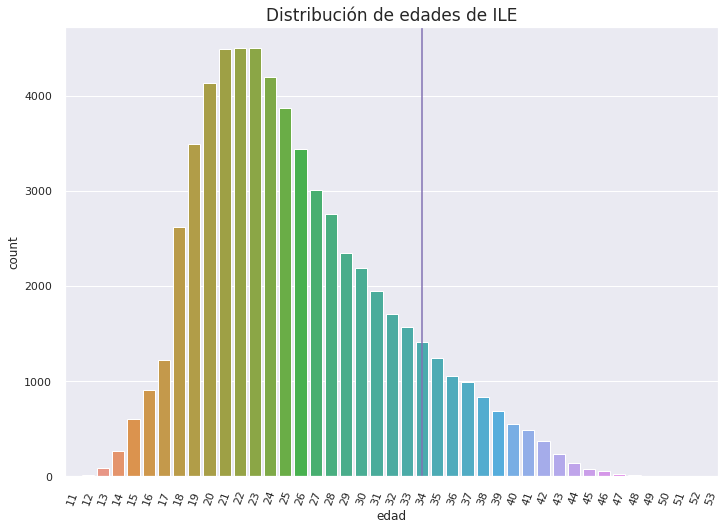

In [10]:
# Distribución de edades

sms.set(rc = {'figure.figsize':(11.7,8.27)})
grafico_edad = sms.countplot(x = "edad", data = ile_estandar)
grafico_edad.set_xticklabels(grafico_edad.get_xticklabels(),rotation = 70)
grafico_edad.set_title('Distribución de edades de ILE',fontsize = 17)
plt.axvline(x=23, color ='m')

En la gráfica anterior se observa que la edad de las personas que acudieron a realizarse la interrupción legal del embarazo varía entre 11 y 53 años, lo cual indica congruencia con la realidad. Se puede notar la presencia de valores extremos; sin embargo la proporción de observaciones correspondientes es mínima.

La distribución de las edades no es simétrica ni alreadedor de la media (25.7), ni alrededor de la edad objetivo (23). En particular se aprecia un mayor volumen de mujeres cuya edad es mayor o igual a 23 años, el cual representa el 63.99% del total de observaciones.


Intuitivamente la variable relacionada con la edad de inicio de la vida sexual activa (fsexual) debería marcar una pauta entre los grupos de edades en cuestión. La gráfica que se muestra a continuación demuestra la presencia de dicho patrón.

Text(0.5, 1.0, 'Edad de incio de relaciones sexuales por grupo de edad')

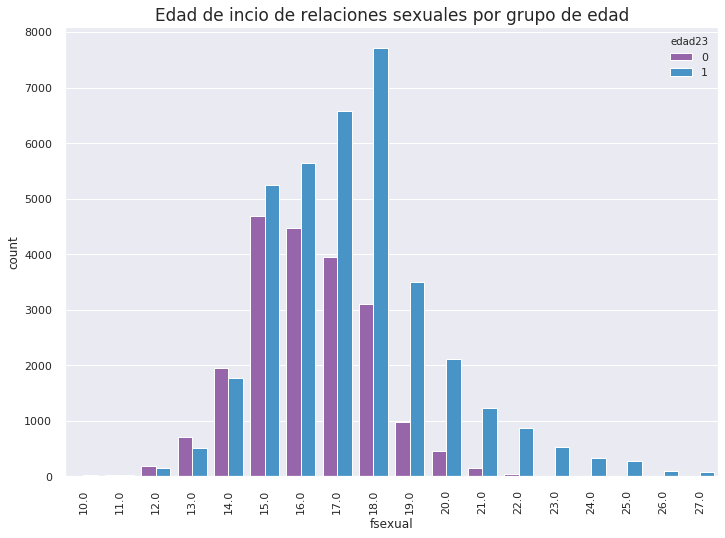

In [11]:
# Edad de inicio de relaciones sexuales por grupo de edad (mayor o igual a 23 o menor)

sms.set(rc = {'figure.figsize':(11.7,8.27)})
grafico_fsexual = sms.countplot(x = 'fsexual',hue = 'edad23',data = ile_estandar.query('fsexual >= 10 and fsexual<=27'), palette= ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])
grafico_fsexual.set_xticklabels(grafico_fsexual.get_xticklabels(), rotation = 90)
grafico_fsexual.set_title('Edad de incio de relaciones sexuales por grupo de edad',fontsize = 17)

Con base en lo anterior se observa que el grupo menor a 23 años inicia su vida sexual activa antes que el grupo mayor o igual a 23 años.

Otra variable que sugiere relevancia en el análisis corresponde al número de hijos (nhijos). En principio el número de hijos del grupo menor a 23 años debería ser menor que el grupo mayor o igual a 23 años. Esta suposición es sustentada por la siguiente gráfica.

Text(0.5, 1.0, 'Distribución del números de hijos por grupo de edad')

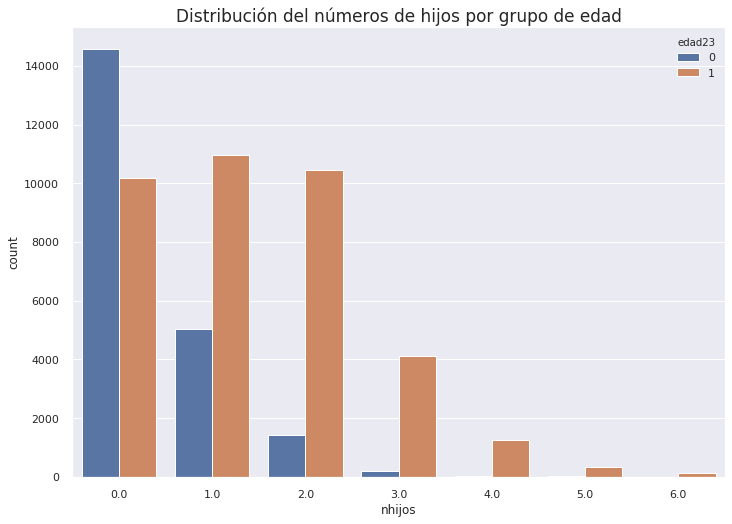

In [12]:
# Número de hijos por grupo de edad

grafico_hijos = sms.countplot(x = 'nhijos',hue = 'edad23',data = ile_estandar.query('nhijos<=6'))
grafico_hijos.set_title('Distribución del números de hijos por grupo de edad',fontsize=17)

Una variable más que podría mostrar conductas por cada grupo de edad, corresponde al número de embarazos incluyendo abortos (gesta).

Text(0.5, 1.0, 'Distribución del número de embarazos por grupo de edad')

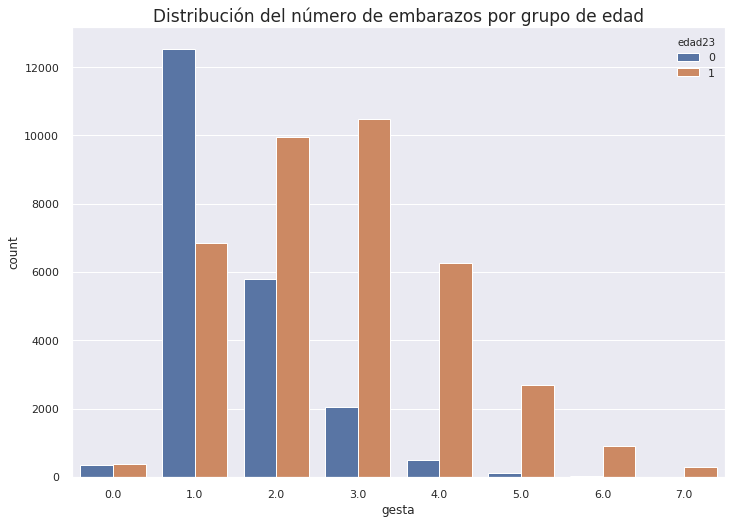

In [13]:
# Número de embarazos (incluyendo abortos) por grupo de edad

grafico_gesta = sms.countplot(x = 'gesta',hue = 'edad23',data = ile_estandar.query('gesta <= 7'))
grafico_gesta.set_title('Distribución del número de embarazos por grupo de edad',fontsize=17)

La grafica anterior da crédito a la noción planteada puesto que se observa una concentración del grupomenor a 23 años en '1'. Nótese que '1' representa el embarazo actual de la mujer. 

Por último se pone atención a la ocupación de los dos grupos de edades, pues tiene sentido inferir que la
mayoría de las mujeres menores a 23 años son estudiantes.

Text(0.5, 1.0, 'Distribución de ocupacion de ILE')

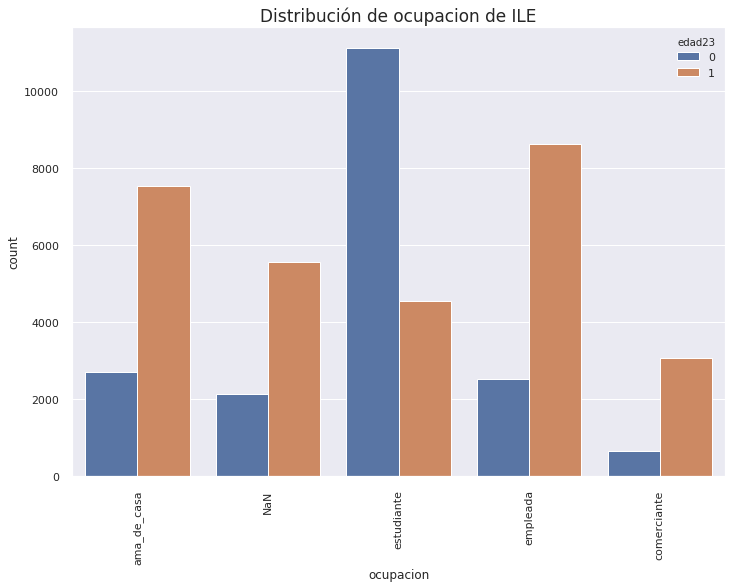

In [14]:
# Top 5 de ocupaciones por grupo de edad

grafico_ocupacion = sms.countplot(x = 'ocupacion',hue = 'edad23',data = ile_estandar.query('ocupacion'+' in (\'ama_de_casa\', \'NaN\', \'estudiante\',\'empleada\',\'comerciante\' )'))
grafico_ocupacion.set_xticklabels(grafico_ocupacion.get_xticklabels(), rotation = 90)
grafico_ocupacion.set_title('Distribución de ocupacion de ILE',fontsize=17)

A manera de conclusión del análisis exploratorio, se presentan los siguientes insights:

+ Existe una relación entre la edad de inicio de la vida sexual y la edad de la mujer, siendo más
probable que la edad de ésta sea menor a 23 cuando su vida sexual inicia alrededor de los 15 años.

+ El número de interrupciones legales de embarazo en los dos grupos de edad se mantiene constante
en el periodo 2016 - 2018; sin embargo la frecuencia disminuye durante el mes de diciembre y se
incrementa en el mes de enero del año consecutivo.

+ En relación a la ocupación del grupo menor a 23 años, se detecta que las que son estudiantes
tienden a esperar más tiempo para llevar cabo la interrupción legal del embarazo, que lasestudiantes pertenecientes al otro grupo de edad.

+ Existe una relación entre el número de hijos que tienen las mujeres mayores a 23; el 74% de ellas
ya tiene un hijo al momento de llevar a cabo la ILE.

+ La Secretaría de Salud de la Ciudad de México señala como uno de los requisitos para llevar cabo la
Interrupción Legal del Embarazo, que la mujer debe acudir con un acompañante; el cual en el caso
de las menores de edad debe ser la madre, el padre, tutor o representante legal. Se observa un
área de oportunidad en el registro de esta información pues el 67.5% de las observaciones no
cuenta con este dato. De contar con esta información, la variable parentesco podría posicionarse
dentro de las más representativas al momento de llevar a cabo la predicción.

#### **2. Selección de Variables**

Los resultados obtenidos a través del EDA permitieron iniciar el Feature Selection con un dataset compuesto por 22 variables.

Dentro de esta sección se implementó un algoritmo de Bosques Aleatorios con la finalidad de seleccionar las variables más relevantes para llevar a cabo la predicción objetivo. 

A manera de resumen el proceso que se siguió para llegar a la selección de variables es el siguiente:

 + Aplicación de One Hot Encoding a las variables categóricas
 + Definición de las variables predictoras y variable target
 + Creación de los conjuntos de entrenamiento y prueba
 + Imputación de valores faltantes para cada conjunto
 + Implementación del algoritmo de Bosques Aleatorios
 + Creación de los dataset (entrenamiento y prueba) con las variables más relevantes


**One Hot Encoding**

In [15]:
# Se aplica One Hot Encoding a las variables categóricas

print('Original Features:\n', list(ile_reducido.columns), '\n')
ile_dummies = pd.get_dummies(ile_reducido)
ile_dummies.head()

Original Features:
 ['año', 'cve_hospital', 'edad', 'menarca', 'fsexual', 'nhijos', 'gesta', 'naborto', 'npartos', 'ncesarea', 'nile', 'c_num', 'p_semgest', 'mes', 'edocivil_descripcion', 'nivel_edu', 'ocupacion', 'parentesco', 'entidad', 'anticonceptivo', 'procile', 's_complica', 'panticoncep', 'edad23'] 



,año,cve_hospital,edad,menarca,fsexual,nhijos,gesta,naborto,npartos,ncesarea,...,panticoncep_diu_t_de_cobre__parches,panticoncep_hormonal_inyectable,panticoncep_implante_subdermico,panticoncep_implante_subdermico__parches,panticoncep_inyeccion__parches,panticoncep_ne,panticoncep_ninguno,panticoncep_otb,panticoncep_otro,panticoncep_parche
0,2016,10,34,11.0,17.0,1.0,3.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2016,1,27,11.0,18.0,1.0,3.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2018,4,29,11.0,15.0,3.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2016,10,33,15.0,17.0,2.0,4.0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2018,7,23,12.0,16.0,1.0,2.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0


**Datos Entrenamiento y Datos Prueba**

In [16]:
# Definición de la matriz de diseño y la variable target

variables_edad = ['edad23','edad']
X = transform_data.eliminar_variables(ile_dummies,variables_edad)
y = ile_dummies.edad23
X.head()


,año,cve_hospital,menarca,fsexual,nhijos,gesta,naborto,npartos,ncesarea,nile,...,panticoncep_diu_t_de_cobre__parches,panticoncep_hormonal_inyectable,panticoncep_implante_subdermico,panticoncep_implante_subdermico__parches,panticoncep_inyeccion__parches,panticoncep_ne,panticoncep_ninguno,panticoncep_otb,panticoncep_otro,panticoncep_parche
0,2016,10,11.0,17.0,1.0,3.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2016,1,11.0,18.0,1.0,3.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2018,4,11.0,15.0,3.0,4.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2016,10,15.0,17.0,2.0,4.0,1.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2018,7,12.0,16.0,1.0,2.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
# Se almacenan los nombres de las columnas de la matriz de diseño, las cuáles serán
# utilizadas más adelante

etiquetas = X.columns
etiquetas

Index(['año', 'cve_hospital', 'menarca', 'fsexual', 'nhijos', 'gesta',
       'naborto', 'npartos', 'ncesarea', 'nile',
       ...
       'panticoncep_diu_t_de_cobre__parches',
       'panticoncep_hormonal_inyectable', 'panticoncep_implante_subdermico',
       'panticoncep_implante_subdermico__parches',
       'panticoncep_inyeccion__parches', 'panticoncep_ne',
       'panticoncep_ninguno', 'panticoncep_otb', 'panticoncep_otro',
       'panticoncep_parche'],
      dtype='object', length=268)

In [18]:
# Se dividen los datos en 20% de prueba y 80% de entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Tamaño datos de entrenamiento',X_train.shape)
print('Tamaño datos de prueba',X_test.shape)
print('Tamaño target de entrenamiento',y_train.shape)
print('Tamaño target de prueba',y_test.shape)

Tamaño datos de entrenamiento (49602, 268)
Tamaño datos de prueba (12401, 268)
Tamaño target de entrenamiento (49602,)
Tamaño target de prueba (12401,)


**Imputación de valores faltantes**

La imputación de los valores faltantes tanto del conjunto de entrenamiento como del conjunto de prueba se llevó a cabo sobre las variables numéricas: menarca', 'fsexual', 'nhijos', 'gesta', 'naborto', 'npartos', 'ncesarea', 'nile', 'c_num' y'p_semgest'. Se determinó que la imputación debía realizarse considerando la mediana de cada variable,de esta forma se tendría un valor "neutro" y se evitaría crear un sesgo debido a la presencia de valores extremos (outliers).

Es importante mencionar que la imputación en ambos conjuntos debe realizarse con los valores de la mediana de cada variable del conjunto de entrenamiento, pues de otra forma se estaría realizando $data leaking$.

In [19]:
#Se imputan los valores faltantes de X_train de las variables numéricas

transformers = [
                ('impute_menarca', SimpleImputer(strategy="median"), ['menarca']),
                ('impute_fsexual', SimpleImputer(strategy="median"), ['fsexual']),
                ('impute_nhijos', SimpleImputer(strategy="median"), ['nhijos']),
                ('impute_gesta', SimpleImputer(strategy="median"), ['gesta']),
                ('impute_naborto', SimpleImputer(strategy="median"), ['naborto']),
                ('impute_npartos', SimpleImputer(strategy="median"), ['npartos']),
                ('impute_ncesarea', SimpleImputer(strategy="median"), ['ncesarea']),
                ('impute_nile', SimpleImputer(strategy="median"), ['nile']),
                ('impute_c_num', SimpleImputer(strategy="median"), ['c_num']),
                ('impute_p_semgest', SimpleImputer(strategy="median"), ['p_semgest'])]
               

col_trans = ColumnTransformer(transformers, remainder="passthrough", n_jobs=1, verbose=True)
col_trans.fit(X_train)
X_train2 = col_trans.transform(X_train)

[ColumnTransformer]  (1 of 11) Processing impute_menarca, total=   0.0s
[ColumnTransformer]  (2 of 11) Processing impute_fsexual, total=   0.0s
[ColumnTransformer]  (3 of 11) Processing impute_nhijos, total=   0.0s
[ColumnTransformer] . (4 of 11) Processing impute_gesta, total=   0.0s
[ColumnTransformer]  (5 of 11) Processing impute_naborto, total=   0.0s
[ColumnTransformer]  (6 of 11) Processing impute_npartos, total=   0.0s
[ColumnTransformer]  (7 of 11) Processing impute_ncesarea, total=   0.0s
[ColumnTransformer] .. (8 of 11) Processing impute_nile, total=   0.0s
[ColumnTransformer] . (9 of 11) Processing impute_c_num, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing impute_p_semgest, total=   0.0s
[ColumnTransformer] ... (11 of 11) Processing remainder, total=   0.0s


In [20]:
#Se imputan los valores faltantes de X_test

transformers = [#('impute_sememb', SimpleImputer(strategy="median"), ['sememb']),
                ('impute_menarca', SimpleImputer(strategy="median"), ['menarca']),
                ('impute_fsexual', SimpleImputer(strategy="median"), ['fsexual']),
                ('impute_nhijos', SimpleImputer(strategy="median"), ['nhijos']),
                ('impute_gesta', SimpleImputer(strategy="median"), ['gesta']),
                ('impute_naborto', SimpleImputer(strategy="median"), ['naborto']),
                ('impute_npartos', SimpleImputer(strategy="median"), ['npartos']),
                ('impute_ncesarea', SimpleImputer(strategy="median"), ['ncesarea']),
                ('impute_nile', SimpleImputer(strategy="median"), ['nile']),
                ('impute_c_num', SimpleImputer(strategy="median"), ['c_num']),
                ('impute_p_semgest', SimpleImputer(strategy="median"), ['p_semgest'])]
               #('impute_p_diasgesta', SimpleImputer(strategy="median"), ['p_diasgesta'])]

col_trans = ColumnTransformer(transformers, remainder="passthrough", n_jobs=1, verbose=True)
col_trans.fit(X_train)
X_test2 = col_trans.transform(X_test)

[ColumnTransformer]  (1 of 11) Processing impute_menarca, total=   0.0s
[ColumnTransformer]  (2 of 11) Processing impute_fsexual, total=   0.0s
[ColumnTransformer]  (3 of 11) Processing impute_nhijos, total=   0.0s
[ColumnTransformer] . (4 of 11) Processing impute_gesta, total=   0.0s
[ColumnTransformer]  (5 of 11) Processing impute_naborto, total=   0.0s
[ColumnTransformer]  (6 of 11) Processing impute_npartos, total=   0.0s
[ColumnTransformer]  (7 of 11) Processing impute_ncesarea, total=   0.0s
[ColumnTransformer] .. (8 of 11) Processing impute_nile, total=   0.0s
[ColumnTransformer] . (9 of 11) Processing impute_c_num, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing impute_p_semgest, total=   0.0s
[ColumnTransformer] ... (11 of 11) Processing remainder, total=   0.0s


In [21]:
# Nombres de las columnas despúes de haber hecho la imputación

# Nombre de las columnas imputadas
transf_labels = ['menarca',
               'fsexual',
                'nhijos',
                'gesta',
                'naborto',
                'npartos',
                'ncesarea',
                'nile',
                'c_num',
                'p_semgest']

# Se eliminan las columnas imputadas del arreglo que contiene el nombre de todas las variables
feat_labels_drop = etiquetas.drop(transf_labels)


# Se obtiene un nuevo arreglo con nombres de las columnas en el orden adecuado después de
# haber hecho la imputación
for element in feat_labels_drop:
    transf_labels.append(element)
    
# A manera de ejemplo se imprime el primer elemento del arreglo que contiene los nombres de las columnas    
transf_labels[0]

'menarca'

**Random Forest para Feature Selection**

Para la implementación del algoritmo de Bosques Aleatorios, se utilizó un índice Gini (threshold) de 0.05. Es
sabido que para un conjunto de datos con dos clases, el índice Gini varía entre 0 y 0.5; 0 si el conjunto de
datos es puro y 0.5 si las dos clases se distribuyen igual. En este conjunto de datos, la distribución de los grupos de
edad no es igual, tiene una mayor proporción el grupo de mujeres mayores a 23 años. Con base lo
anterior, se justifica el threshold utilizado en el proceso de Feature Selection.

In [22]:
# Se crea el clasificador Random Forest
clf_randomForest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

# Se entrena al clasificador
clf_randomForest.fit(X_train2, y_train)

# Se imprimen los nombres y "gini importance" para cada variable
#for feature in zip(transf_labels, clf.feature_importances_):
#    print(feature)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
# Se crea un objecto selector que utilizará el clasificador random forest para
# identificar variables que tienen una importancia mayor a cierto valor

selector = SelectFromModel(clf_randomForest, threshold=0.05)

# Se entrena al selector
selector.fit(X_train2, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
        

In [24]:
# Se imprimen los nombres de las variables más relevantes conforme a lo establecido

for feature_list_index in selector.get_support(indices=True):
    print(transf_labels[feature_list_index])

fsexual
nhijos
gesta
npartos


El método anterior seleccionó exclusivamente cuatro variables para generar el modelo de clasificación; las
cuáles se enlistan en seguida:

+ fsexual
+ nhijos
+ gesta
+ npartos

Comparando estas variables con el análisis exploratorio de los datos, se muestra congruencia.

**Creación del nuevo conjunto de datos**

Se procede a construir el conjunto de datos con las variables más relevantes determinadas por el algoritmo de Bosques Aleatorios.

In [25]:
# Se transforman los datos para crear un nuevo dataset que contenga únicamente las
# variables más relevantes.
# Se debe aplicar la transformación a ambos conjuntos: el de prueba y el de entrenamiento

X_important_train = selector.transform(X_train2)
X_important_test = selector.transform(X_test2)

X_important_train[0]

array([17.,  3.,  4.,  2.])

#### **3. Modelos**

De manera general, en esta sección se generarán tres modelos para llevar a cabo la predicción
planteada: Bosques Aleatorios, Árboles de Decisión y XGBoost. Con el propósito de determinar los mejores
parámetros para cada uno de ellos, se implementará un magic loop, dentro del cual será incluida la validación cruzada de 5 folds para evitar sobreajuste en el
entrenamiento de los modelos. El desempeño de los modelos será monitoreado a través de la métrica:
recall.

Para este problema en concreto recall representa el cociente de mujeres cuya edad es mayor o igual a 23 en relación al total de mujeres que tienen al menos 23 años (mayor o igual a 23), es decir, recall permite identificar el porcentaje correcto de predicciones del grupo que tiene mayor presencia (mayor a 23 años)
en el conjunto de datos disponible.

**Definición de Modelos y Magic Loop**

In [26]:
# Definición de la función seleccionar_modelos, que será la encargada de seleccionar el modelo, dependiendo el nombre que reciba

def seleccionar_modelos(lista_modelos):
    
    config_modelos = np.array([])
    for modelo in lista_modelos:
        
        if modelo =='DECTREE':
            clasificador = DecisionTreeClassifier()
        if modelo =='RANDOMF':
            clasificador = RandomForestClassifier()
        if modelo =='XGBOOST':
            clasificador = GradientBoostingClassifier()
        
        config_modelos = np.append(config_modelos, clasificador)
        
    return config_modelos

# Definición de la función magic_loop, la cual se encargará de correr los modelos con sus diferentes hyperparametros-
def magic_loop(configuracion_modelos, hyperParametros, X_train, Y_train, num_folds):
    
    resultados = np.array([])
    for i, clasificador in enumerate(configuracion_modelos):
        hyperParametros_modelo = hyperParametros[i]
        
        grid_search = GridSearchCV(clasificador
                                  ,hyperParametros_modelo
                                  ,scoring = 'recall'
                                  ,cv = num_folds
                                  ,n_jobs = -1
                                  ,verbose = 3
                                  )
        grid_search.fit(X_train, Y_train)
        cv_resultados = pd.DataFrame(grid_search.cv_results_)
        resultados_ordenados = cv_resultados.sort_values(by='rank_test_score', ascending=True)
        
        resultados = np.append(resultados, resultados_ordenados)
        
        # Se imprime los mejores hiperparámetros de todos los valores posibles que se incluyeron en el grid
        print('grid_search.best_params_: ', grid_search.best_params_)

        # Mejor score asociado a los modelos generados con los diferentes hiperparámetros,
        # corresponde al promedio de los scores generados durante la validación cruzada
        print('grid_search.best_score_: ', grid_search.best_score_)

        
    return resultados


Se definen los parámetros a utilizar para cada modelo

In [27]:
#Definición de hyperparámetros para cada uno de los tres modelos

# Se definen los hyperparámetros de RandomForest
hyperParam_randomForest = {'n_estimators': [1,3,7,12], 
                    'max_depth': [1,3,7,12], 
                    'max_features': ['sqrt','log2'],
                    'min_samples_split': [2,3,7,12]}



# Se definen los hyperparámetros de XGBoost
hyperParam_xgboost = {'learning_rate': [0.1,0.3,0.7], 
                    'max_depth': [2,5,8], 
                    'max_features': ['sqrt','log2'],
                    'min_samples_split': [2,3,7],
                    'min_samples_leaf': [2,4,8]}


# Se definen los hyperparámetros de DecisionTree
hyperParam_decisionTree = {'min_samples_split': [2,3,7], 
                  'max_depth': [1,5,10], 
                  'max_features': ['sqrt','log2'],
                  'min_samples_leaf': [1,3,5]}

hyperParametros = np.array([hyperParam_randomForest,hyperParam_xgboost,hyperParam_decisionTree])


Se definen los modelos a correr:

In [28]:
#Modelos a implementar
nombres_modelos = np.array(['RANDOMF','XGBOOST','DECTREE'])
config_modelos = seleccionar_modelos(nombres_modelos)

Se corre el Magic Loop

In [29]:
resultados_magicloop = magic_loop(config_modelos, hyperParametros, X_important_train,y_train,5) 

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 523 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 633 out of 640 | elapsed:   26.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


grid_search.best_params_:  {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 1}
grid_search.best_score_:  0.8976279225624292
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 16.1min finished


grid_search.best_params_:  {'learning_rate': 0.7, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2}
grid_search.best_score_:  0.8515975548112606
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


grid_search.best_params_:  {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3}
grid_search.best_score_:  0.912565858168313


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    3.0s finished


**Implementación del mejor modelo para predicción**

In [35]:
# Definición del modelo con los mejores parámetros
model = DecisionTreeClassifier(max_depth = 1, max_features= 'sqrt', min_samples_leaf = 3, min_samples_split = 3)

# Implementación de la validación cruzada utilizando la métrica de recall y el modelo antes asignado.
# Esto generará el score del modelo y lo comparará con el real. Se obtiene además el recall de cada uno de los folds.

cv = cross_validate(model, X_important_train, y_train, cv=5,scoring = 'recall')
print(cv['test_score'])
print(cv['test_score'].mean())

[1.         0.821046   0.81805293 1.         0.81250985]
0.8903217551936727


In [36]:
# Se utiliza la función cross_val_predict para obtener las predicciones del conjunto de datos

y_pred = cross_val_predict(model, X_important_train, y_train, cv=5)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

**Evaluación off-line**

In [37]:
# Matriz de confusión
mc = confusion_matrix(y_train, y_pred)
mc

array([[ 8790,  9074],
       [ 5582, 26156]])

In [38]:
# Definición de la función graficar_matrizConfusion que imprime y grafica la matriz de confusión.
# La normalzización puede aplicarse al especificar normalizar = True



def graficar_matrizConfusion(y_true, y_pred,
                          normalizar = False,
                          cmap = plt.cm.Blues):
    
    
    ######Cálculo matriz de confusión
    matriz_confusion = confusion_matrix(y_true, y_pred)
    
    if normalizar:
        
        # Se calcula la matriz de confusión normalizada
        matriz_confusion = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
        
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalización')

    print(matriz_confusion)
    
  
    ######Gráfica de la matriz de confusión
    # Título de la gráfica de la matriz de confusión
    if normalizar:
        titulo = 'Matriz de Confusión Normalizada'
    else:
        titulo = 'Matriz de Confusión sin Normalización'

        
    # etiquetas de la variable target
    nombres_clases = unique_labels(y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(matriz_confusion, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax=ax)
    
    
    # Se quieren mostrar los valores de cada sección de la matriz de confusión...
    ax.set(xticks = np.arange(matriz_confusion.shape[1]),
           yticks = np.arange(matriz_confusion.shape[0]),
           
           # ...y las etiquetas respectivas
           xticklabels = nombres_clases, yticklabels = nombres_clases,
           title = titulo,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    
    # Se rotan las etiquetas y se fija su alineación
    plt.setp(ax.get_xticklabels(), rotation=90, ha = "right", rotation_mode = "anchor")

    # Loop sobre las dimensiones de los datos y creación de los textos de cada sección de la matriz
    fmt = '.2f' if normalizar else 'd'
    thresh = matriz_confusion.max() / 2.
    for i in range(matriz_confusion.shape[0]):
        for j in range(matriz_confusion.shape[1]):
            ax.text(j, i, format(matriz_confusion[i, j], fmt),
                    ha = "center", va = "center",
                    color = "white" if matriz_confusion[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Matriz de Confusión Normalizada
[[0.49205105 0.50794895]
 [0.1758775  0.8241225 ]]


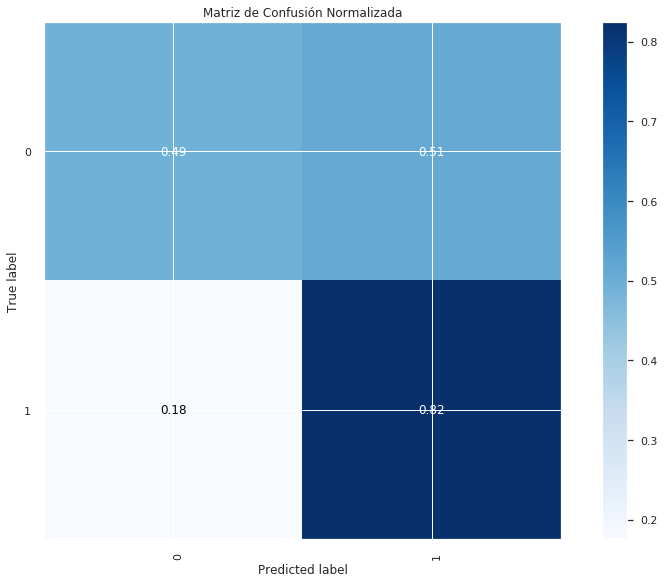

In [39]:
# Matriz de confusión normalizada

#class_names = np.array([1,0])
graficar_matrizConfusion(y_train, y_pred,normalizar = True,cmap = plt.cm.Blues)



Para poder interpretar la matriz de confusión, es importante establecer los significados de Positivo y
Negativo. Por un lado Positivo corresponde al grupo de edades mayor o igual a 23 años; mientras que
Negativo hace referencia al grupo menor a 23 años.

De acuerdo a la clasificación anterior se pueden definir las siguientes combinaciones:
+ TP: El modelo predijo mayor o igual a 23 y la edad real es mayor o igual a 23 años.
+ FP: El modelo predijo mayor o igual a 23 años y la edd real es menor a 23 .
+ TN: El modelo predijo menor a 23 años y la edad real es menor a 23.
+ FN: El modelo predijo menor a 23 años y la edad real es mayor o igual a 23.

La matriz de confusión da lugar a las siguientes observaciones:

+ Para el grupo de mujeres cuya edad es mayor o igual a 23 años, el modelo predice correctamente el 82% de las observaciones, es decir, identifica 82% de los Verdaderos Positivos.
+ En el caso de mujeres cuya edad es menor a 23 años, el modelo predice correctamente el 49% de las observaciones (Verdaderos Negativos).
+ El modelo identica erróneamente el 18% de los datos mayores o iguales a 23 años. Por otro lado, el error en los datos menores a 23 años es del 51%.

Con base en lo anterior se determina que el modelo predice mejor el grupo de edades maayor o igual a 23 años, es decir, predice mejor los Verdaderos Positivos.
